In [ ]:
import pandas as pd
# import mplfinance as mpf
import datetime
from datetime import date
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.layers import LSTM
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten, SimpleRNN, GRU
from keras.datasets import mnist
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dropout
import matplotlib.pyplot as plt
# !pip install eli5
import lightgbm as lgb

def transform_date(date):   #民國轉西元
  y, m, d = date.split('/')
  return str(int(y)+1911) + '/' + m  + '/' + d

def transform(data):   #讀取每一個元素進行資料格式轉換，再產生新的串列
  return [transform_date(d) for d in data]


def create_GRU(x_train, y_train, x_test, y_test):
  batch_size = None
  steps = 30
  input_dim = x_train.shape[2]
  epochs = 60

  model = Sequential()
  # 加 RNN 隱藏層(hidden layer)
  model.add(GRU(
      # 如果後端使用tensorflow，batch_input_shape 的 batch_size 需設為 None.
      # 否則執行 model.evaluate() 會有錯誤產生.
      batch_input_shape=(batch_size, steps, input_dim), 
      units= 50,
      unroll=True,
      return_sequences=True
  ))
  model.add(GRU(
      units= 50,
      unroll=True,
  ))
  model.add(Dropout(0.2))
  model.add(Dense(20))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
  hist = model.fit(x_train, y_train,
            batch_size=batch_size, epochs=epochs,
            verbose=1, validation_data=(x_test, y_test))
  # plt.figure(figsize=(12,6))
  # lgb.plot_importance(model, max_num_features=30)
  # plt.title("Featurertances")
  # plt.show()
  return hist, model

def plot_loss(hist, modelname):
  name = modelname+" loss"
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.title(modelname+" loss")
  plt.savefig(name)
  plt.show()

def denormalized(data, data_normalize):
  denormal = data_normalize*(data['close'].max()-data['close'].min())+data['close'].min()
  return denormal

def plot_predict_close(x_test, y_test, model, modelname, data):
  predict_y = model.predict(x_test)
  
  denormal_predict_y = denormalized(data, predict_y)
  denormal_y = denormalized(data, y_test)
  name = modelname+' prediction'
  plt.plot(denormal_y)
  plt.plot(denormal_predict_y)
  plt.legend(['True', 'Predict'], loc='upper right')
  plt.title(name)
  plt.savefig(name)
  plt.show()

In [ ]:
data = pd.read_csv('final.csv',parse_dates=True)
# data['date'] = transform(data['date']) #民國轉西元
data['date']= pd.to_datetime(data['date'])
# _ = data.pop('Unnamed: 0')
# _ = data.pop('Unnamed: 0.1')

notnumber_idx = np.where(data['price_difference'] == 'X0.00')
for idx in notnumber_idx:
  # print(idx)
  data.iloc[idx] = 0

data.set_index('date',inplace=True)
data['price_difference'] = data['price_difference'].astype(float)

data

,volume,open,high,low,close,price_difference,ma10,ma30,rsi,macd,macdsignal,macdhist,snownlp,bert
date,,,,,,,,,,,,,,
2018-01-02,18055269,231.5,232.5,231.0,232.5,3.0,226.95,230.566667,55.637154,-1.349964,-2.103347,0.753382,0.856003,-1.0
2018-01-10,25716220,241.5,242.0,236.0,236.5,-5.5,235.00,230.383333,55.917239,2.147262,0.535082,1.612180,0.064607,-1.0
2018-01-18,50119952,245.0,250.0,245.0,248.5,6.5,240.35,232.416667,70.575297,3.246930,2.010839,1.236091,0.797685,-1.0
2018-01-19,55061292,253.5,255.5,251.5,255.5,7.0,241.90,233.383333,76.077091,4.295089,2.467689,1.827400,0.252070,-1.0
2018-01-22,45907509,257.5,262.0,257.0,261.5,6.0,243.85,234.533333,79.598332,5.545982,3.083348,2.462634,0.033804,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,18320849,508.0,511.0,506.0,509.0,0.0,510.40,498.316667,57.213294,9.166206,11.016050,-1.849844,0.419833,-1.0
2020-12-28,19520886,512.0,515.0,509.0,515.0,4.0,510.40,502.716667,60.922174,7.986220,9.637496,-1.651276,0.429577,0.0
2020-12-29,20226736,515.0,517.0,513.0,515.0,0.0,511.50,503.700000,60.922174,7.785855,9.267168,-1.481313,0.298955,0.0


In [ ]:
# _ = data.pop('snownlp')
# _ = data.pop('bert')
data_normalize = (data-data.min())/(data.max()-data.min())

# idx = (data_normalize.shape[0]*3)//4
idx = 300
trainData = data_normalize.iloc[:idx,:]
testData = data_normalize.iloc[idx:, :]
y_trainData = trainData.pop('close')
y_testData = testData.pop('close')

data_normalize
# d_y = denormalized(data, y)
# trainData, testData, y_trainData, y_testData = train_test_split(data_normalize, y, test_size = 0.2, random_state = 0)
# d_y

,volume,open,high,low,close,price_difference,ma10,ma30,rsi,macd,macdsignal,macdhist,snownlp,bert
date,,,,,,,,,,,,,,
2018-01-02,0.026970,0.065079,0.058544,0.066879,0.064465,0.354545,0.037748,0.038016,0.540682,0.355759,0.306970,0.557087,0.859256,0.0
2018-01-10,0.075343,0.096825,0.088608,0.082803,0.077044,0.200000,0.064640,0.037376,0.544440,0.435152,0.374975,0.624620,0.064812,0.0
2018-01-18,0.229432,0.107937,0.113924,0.111465,0.114780,0.418182,0.082512,0.044478,0.741069,0.460116,0.413012,0.595046,0.800714,0.0
2018-01-19,0.260633,0.134921,0.131329,0.132166,0.136792,0.427273,0.087690,0.047855,0.814873,0.483911,0.424788,0.641544,0.252997,0.0
2018-01-22,0.202834,0.147619,0.151899,0.149682,0.155660,0.409091,0.094204,0.051872,0.862108,0.512308,0.440656,0.691496,0.033891,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,0.028647,0.942857,0.939873,0.942675,0.933962,0.300000,0.984633,0.973278,0.561825,0.594493,0.645121,0.352379,0.421406,0.0
2020-12-28,0.036224,0.955556,0.952532,0.952229,0.952830,0.372727,0.984633,0.988648,0.611578,0.567706,0.609589,0.367994,0.431187,0.5
2020-12-29,0.040681,0.965079,0.958861,0.964968,0.952830,0.300000,0.988308,0.992082,0.611578,0.563157,0.600044,0.381359,0.300062,0.5


In [ ]:
x_train = []   #預測點的前 days 天的資料
y_train = []   #預測點
x_test = []
y_test = []
days = 30
for i in range(days, trainData.shape[0]):  # trainData.shape[0] 是訓練集總數
    x_train.append(trainData.iloc[i-days:i, :])
    # print(i)
    # print((trainData.iloc[i-days:i, :].shape))
    y_train.append(y_trainData.iloc[i])
for i in range(days, testData.shape[0]):
    x_test.append(testData.iloc[i-days:i, :])
    y_test.append(y_testData.iloc[i])
x_train, y_train = np.array(x_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN
x_test, y_test = np.array(x_test), np.array(y_test)
# y_testData 



In [ ]:
GRU_hist, GRU = create_GRU(x_train, y_train, x_test, y_test)

Epoch 1/60
9/9 [==============================] - 14s 226ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 2/60
9/9 [==============================] - 0s 23ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 3/60
9/9 [==============================] - 0s 24ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0226 - val_mean_squared_error: 0.0226
Epoch 4/60
9/9 [==============================] - 0s 24ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 5/60
9/9 [==============================] - 0s 24ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 6/60
9/9 [==============================] - 0s 24ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 7/60
9/9 [============================

In [ ]:
plot_loss(GRU_hist, 'GRU')

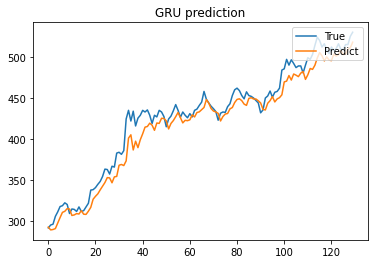

In [ ]:
plot_predict_close(x_test, y_test, GRU, "GRU", data)

In [ ]:

def var_importance(model,x):
  
  orig_out = model.predict(x)
  for i in range(x_train.shape[2]):  # iterate over the three features
    new_x = x.copy()
    perturbation = np.random.normal(0.0, 0.2, size=new_x.shape[:2])
    new_x[:, :, i] = new_x[:, :, i] + perturbation
    perturbed_out = model.predict(new_x)
    effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5
    
    print(trainData.columns[i]+ f' perturbation effect: {effect:.4f}')

In [ ]:
var_importance(GRU, x_train)

volume perturbation effect: 0.0027
open perturbation effect: 0.0128
high perturbation effect: 0.0292
low perturbation effect: 0.0049
price_difference perturbation effect: 0.0046
ma10 perturbation effect: 0.0144
ma30 perturbation effect: 0.0025
rsi perturbation effect: 0.0102
macd perturbation effect: 0.0031
macdsignal perturbation effect: 0.0034
macdhist perturbation effect: 0.0084
snownlp perturbation effect: 0.0025
bert perturbation effect: 0.0052
